> ### Name : Meet Gera
> ### Roll Number : 2022102039

#### Question 5 : Auto Encoder

##### 5.1 Implement the encoder and decoder using PyTorch

> - Encoder : Compresses input into bottleneck
> - Decoder : Expands/ Reconstructs input from bottleneck

In [115]:
#### Environment setup
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [116]:
bottleneck_dims  = [16, 8, 4, 2]
results = {}

In [117]:
### AutoEncoder Class 
class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_dim=32):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # MNIST pixels are between 0 and 1
        )

    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten image
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [118]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform 
transform = transforms.Compose([
    transforms.ToTensor()
])

# Data Import 
train_data = datasets.MNIST(root='./data',train = True, download = True, transform = transform)
test_data = datasets.MNIST(root= './data', train = False, download = True, transform = transform)

# Get Roll Number's last digit data 
normal_digit = 9
train_indices = [i for i,(img, label) in enumerate(train_data) if label == normal_digit]
train_subset = Subset(train_data, train_indices)

# Dataloaders
train_loader = DataLoader(train_subset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

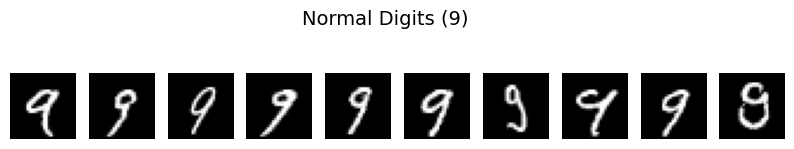

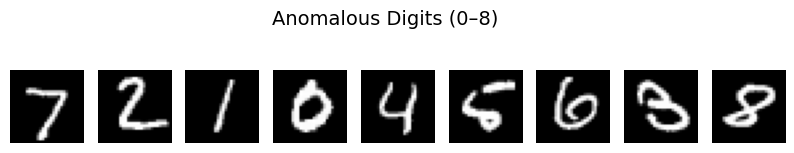

In [119]:
def show_samples(dataset, label_filter, title, num_samples=10):
    filtered = [(img, label) for img, label in dataset if label == label_filter]
    imgs = [img for img, _ in filtered[:num_samples]]
    
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.show()

# Show 10 normal digit 9s from training set
show_samples(train_data, label_filter=9, title="Normal Digits (9)")

def show_anomaly_samples(dataset, exclude_label, num_classes=9):
    seen_labels = set()
    images = []
    for img, label in dataset:
        if label != exclude_label and label not in seen_labels:
            images.append(img)
            seen_labels.add(label)
        if len(seen_labels) == num_classes:
            break
    
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(images):
        plt.subplot(1, num_classes, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        # plt.title(f"{list(seen_labels)[i]}")
    plt.suptitle("Anomalous Digits (0–8)", fontsize=14)
    plt.show()

# Show one example from each anomaly class
show_anomaly_samples(test_data, exclude_label=9)

In [120]:
for bottleneck_dim in bottleneck_dims:
    
    # Training Part
    # Model, loss, optimizer
    model = AutoEncoder(bottleneck_dim=bottleneck_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop
    n_epochs = 30
    
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
    
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            
            # Forward
            outputs = model(imgs)
            loss = criterion(outputs, imgs.view(-1, 28*28))
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
    
        epoch_loss = running_loss / len(train_loader.dataset)
        # print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}")
    
    
    #Inferencing
    model.eval()
    reconstruction_errors = []
    labels = []
    
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = F.mse_loss(outputs, imgs.view(-1, 28*28), reduction='none')
            
            # Compute MSE per image
            loss_per_image = loss.mean(dim=1).cpu().numpy()
            reconstruction_errors.extend(loss_per_image)
            labels.extend(lbls.cpu().numpy())
    
    reconstruction_errors = np.array(reconstruction_errors)
    labels = np.array(labels)
    results[bottleneck_dim] = {'errors': reconstruction_errors, 'labels':labels}

Results for Bottleneck dimension = 16


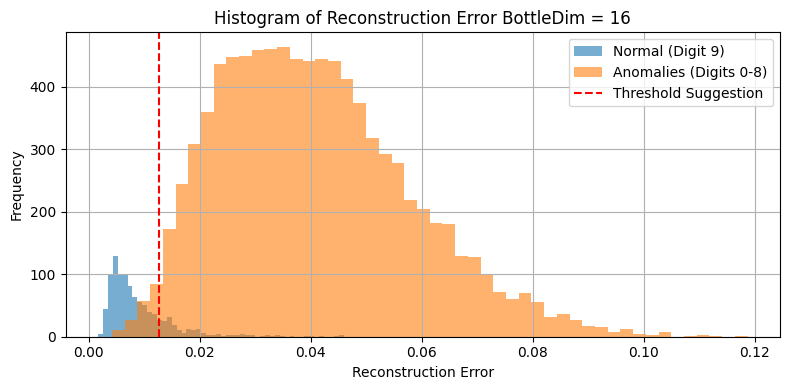

Threshold : 0.0127
Precision: 0.8494
Recall:    0.8107
F1-score:  0.8296
Results for Bottleneck dimension = 8


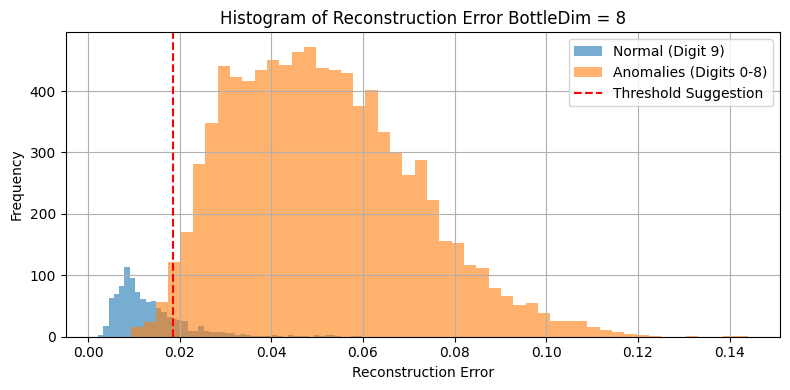

Threshold : 0.0185
Precision: 0.8562
Recall:    0.8087
F1-score:  0.8318
Results for Bottleneck dimension = 4


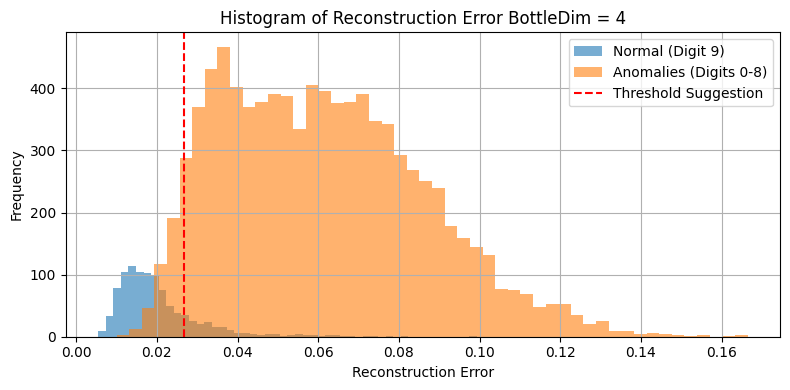

Threshold : 0.0268
Precision: 0.6407
Recall:    0.8147
F1-score:  0.7173
Results for Bottleneck dimension = 2


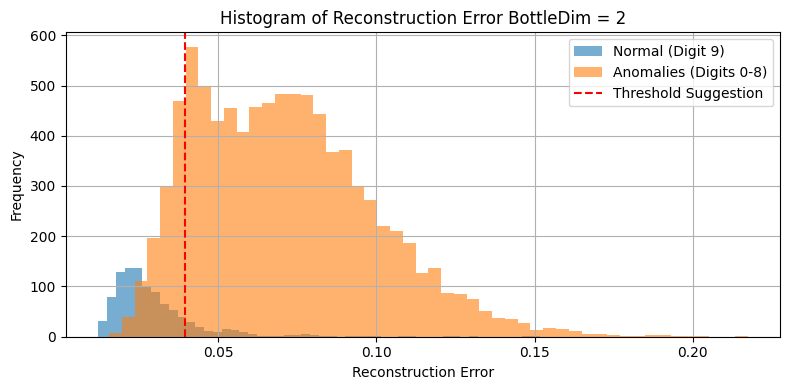

Threshold : 0.0394
Precision: 0.4391
Recall:    0.8434
F1-score:  0.5775


In [166]:
for bottleneck_dim in bottleneck_dims :
# Separate normal and anomaly errors
    std_dev_factor = 0.6
    reconstruction_errors = results[bottleneck_dim]['errors']
    labels = results[bottleneck_dim]['labels']
    normal_errors = reconstruction_errors[labels == 9]
    anomaly_errors = reconstruction_errors[labels != 9]
    print(f"Results for Bottleneck dimension = {bottleneck_dim}")
    plt.figure(figsize=(8, 4))
    plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal (Digit 9)')
    plt.hist(anomaly_errors, bins=50, alpha=0.6, label='Anomalies (Digits 0-8)')
    plt.axvline(x=np.mean(normal_errors) + std_dev_factor*np.std(normal_errors) , color='red', linestyle='--', label='Threshold Suggestion')
    plt.title(f"Histogram of Reconstruction Error BottleDim = {bottleneck_dim}")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    threshold = np.mean(normal_errors) + std_dev_factor * np.std(normal_errors) 
    print(f"Threshold : {threshold:.4f}")
    # Ground truth: 0 if anomaly (digits 0–8), 1 if normal (digit 9)
    true_labels = (labels == 9).astype(int)
    
    # Predicted: 1 if below threshold (normal), 0 if anomaly
    pred_labels = (reconstruction_errors < threshold).astype(int)
    
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    results[bottleneck_dim]["Threshold"] = threshold
    results[bottleneck_dim]["Precision"] = precision
    results[bottleneck_dim]["Recall"] = recall
    results[bottleneck_dim]["F1-Score"] = f1
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")

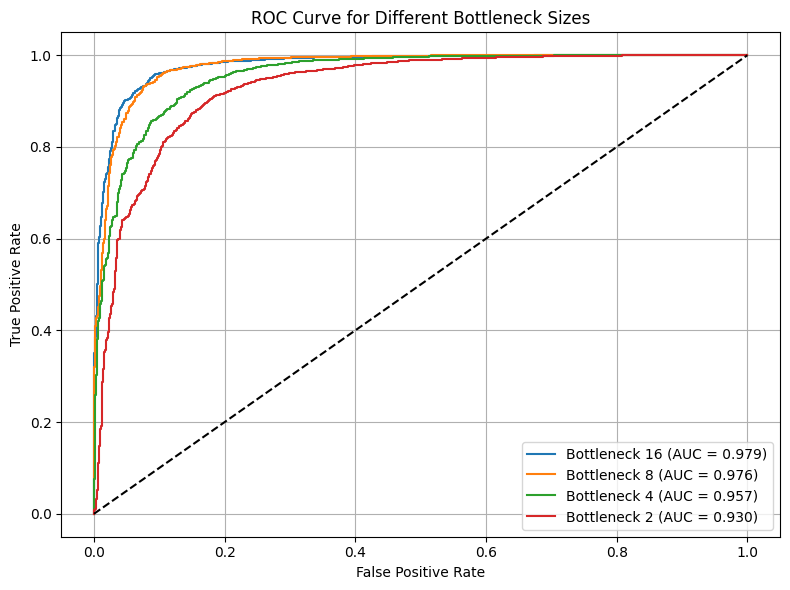

In [168]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for bottleneck, data in results.items():
    errors = data['errors']
    labels = data['labels']
    binary_labels = np.where(labels == 9,0,1)
    assert np.all(errors >= 0), "Reconstruction errors should be non-negative"
    fpr, tpr, thresholds = roc_curve(y_true = binary_labels,y_score = errors)
    auc_score = auc(fpr, tpr)
    data['auc'] = auc_score  
    plt.plot(fpr, tpr, label=f'Bottleneck {bottleneck} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Bottleneck Sizes')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()